1、使用直方图重述基本全局阈值法

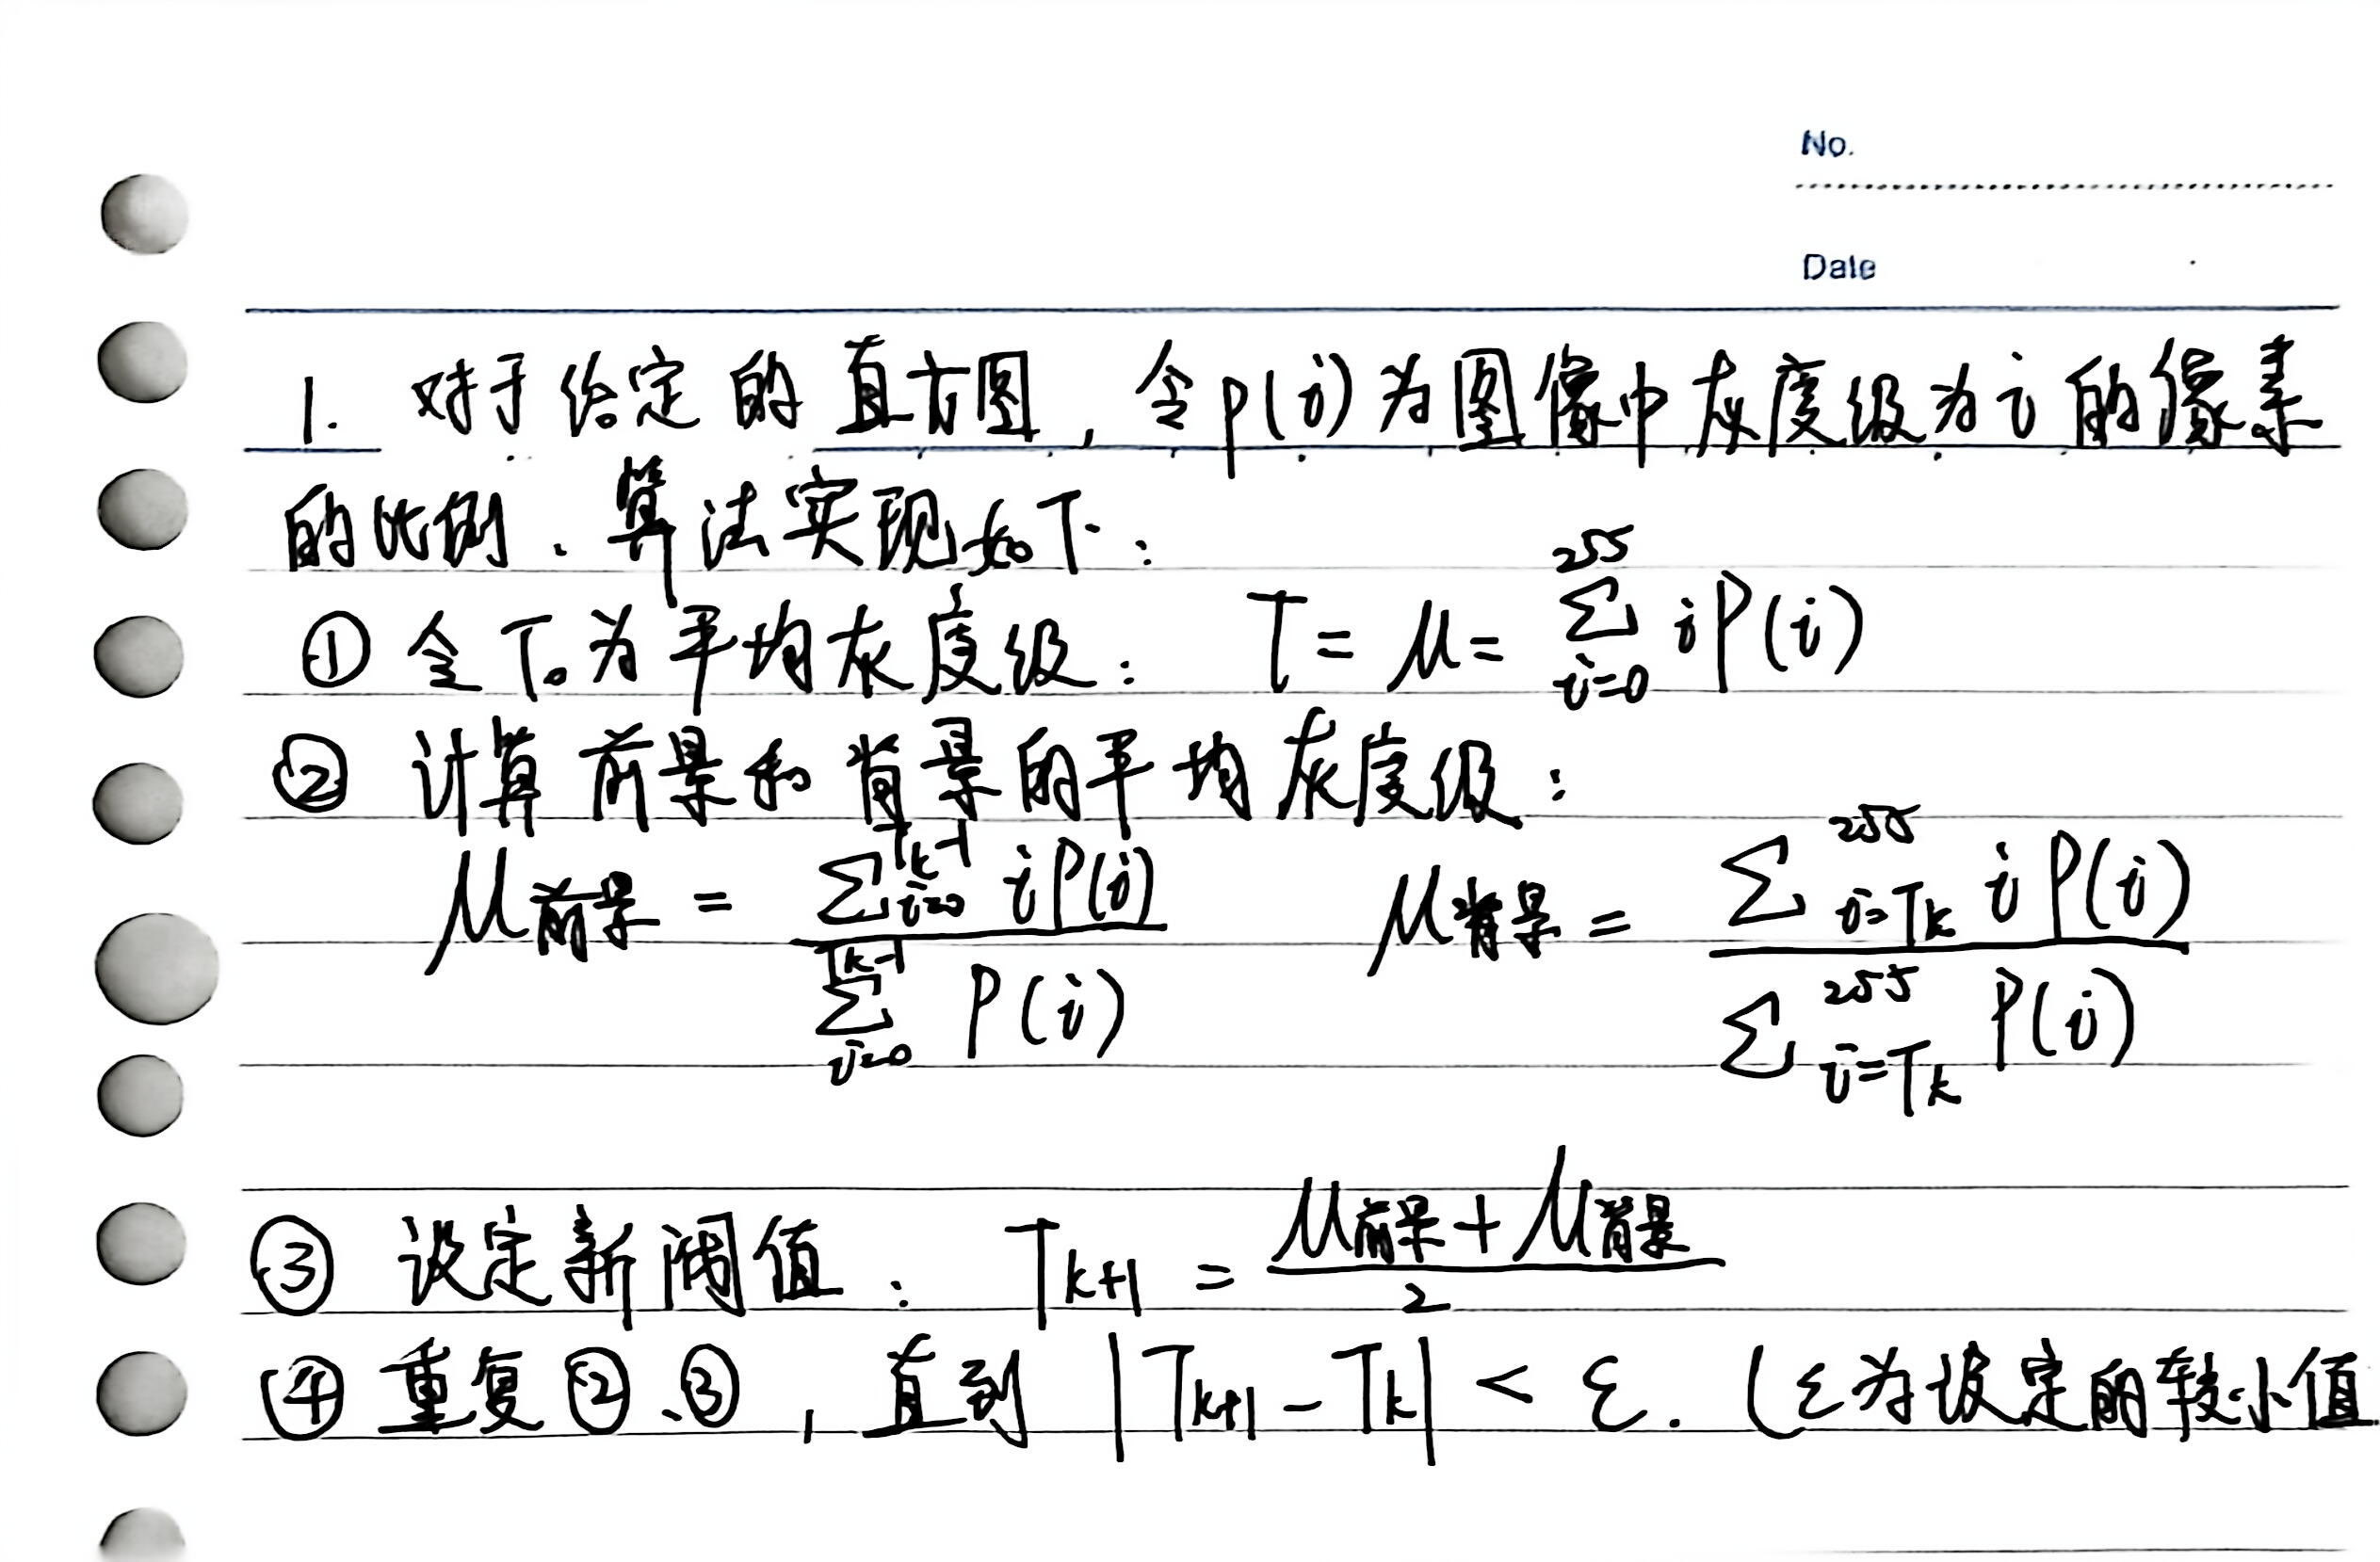

2、创建local-list函数，该函数能够根据所输入的patch size，返回对应于图像中所有像素点的局部灰度值直方图。
对于每个像素点以及该像素点所对应的局部直方图，使用OTSU算法

In [3]:
from math import *
import numpy as np
from PIL import Image


def local_hist(pixels, w):
    # 验证输入
    if w % 2 == 0:
        raise ValueError("w must be an odd number")

    # 确保像素值在正确范围内
    pixels = np.clip(pixels, 0, 255).astype(np.uint8)

    count = 0
    hist = np.zeros((pixels.size, 2 + 256), dtype=np.int32)

    for i in range(pixels.shape[0]):
        up = max(0, i - w // 2)
        down = min(pixels.shape[0] - 1, i + w // 2)
        for j in range(pixels.shape[1]):
            if j == 0:
                hist[count, 0] = i
                hist[count, 1] = j
                rt = min(pixels.shape[1] - 1, j + w // 2)
                for p in range(up, down + 1):
                    for q in range(rt + 1):
                        pixel_val = int(pixels[p, q])
                        hist[count, 2 + pixel_val] += 1
                count += 1
            else:
                hist[count, :] = hist[count - 1, :]
                hist[count, 0] = i
                hist[count, 1] = j
                lf = max(0, j - w // 2)
                rt = min(pixels.shape[1] - 1, j + w // 2)
                if lf == 0:
                    old_col = []
                else:
                    old_col = pixels[up:down + 1, lf - 1]
                if j + w // 2 > rt:
                    new_col = []
                else:
                    new_col = pixels[up:down + 1, rt]

                for item in old_col:
                    item_val = int(item)
                    hist[count, 2 + item_val] -= 1
                for item in new_col:
                    item_val = int(item)
                    hist[count, 2 + item_val] += 1
                count = count + 1
    return hist


def local_adaptive_thresholding(pixel, hist):
    # 提取直方图部分（去掉前两个坐标值）
    hist_data = hist[2:]

    S = int(sum(hist_data))
    if S == 0:  # 添加边界条件检查
        return 0

    one_hist = hist_data / S
    mu_global = np.inner(one_hist, np.array(range(256)))
    T = 127
    sigma = -float('inf')

    for t in range(1, 255):
        if hist_data[t] == 0:
            continue

        omega_bk = sum(one_hist[0:t])
        if omega_bk == 0 or omega_bk == 1:  # 修正边界条件
            continue

        mean_bk = np.inner(one_hist[0:t], np.array(range(t))) / omega_bk  # 修正均值计算
        mean_fg = np.inner(one_hist[t:], np.array(range(t, 256))) / (1 - omega_bk)  # 计算前景均值

        # 使用Otsu方法的类间方差公式
        sigma_new = omega_bk * (1 - omega_bk) * (mean_bk - mean_fg) ** 2

        if sigma_new > sigma:
            sigma = sigma_new
            T = t

    if pixel > T:
        return 255
    else:
        return 0


def main():
    myPicture = '细胞.png'
    im_raw = Image.open(myPicture)
    im = im_raw.convert('L')
    pixels = np.array(im)

    # 确保patch_size是奇数
    patch_size = 0
    while patch_size % 2 == 0 or patch_size <= 0:
        patch_size = int(input('请输入patch size（必须是奇数）: '))
        if patch_size % 2 == 0:
            print("错误：patch size必须是奇数！")

    # 计算局部直方图
    hist_list = local_hist(pixels, patch_size)

    # 获取图像尺寸
    height, width = pixels.shape

    # 创建结果图像
    result = np.zeros_like(pixels)

    # 对每个像素应用局部自适应阈值
    for i in range(height):
        for j in range(width):
            # 获取当前像素的局部直方图
            # 注意：local_hist返回的数组是按行主序排列的，所以索引是 i * width + j
            idx = i * width + j
            local_histogram = hist_list[idx]

            # 应用阈值处理
            result[i, j] = local_adaptive_thresholding(pixels[i, j], local_histogram)

    # 保存结果
    result_image = Image.fromarray(result.astype(np.uint8))
    result_image.save('local_adaptive_threshold_result.png')
    result_image.show()

    print("处理完成！结果已保存为 'local_adaptive_threshold_result.png'")


if __name__ == "__main__":
    main()

请输入patch size（必须是奇数）:  25


处理完成！结果已保存为 'local_adaptive_threshold_result.png'


分别取patch size为25，51，101和151时输出图像。

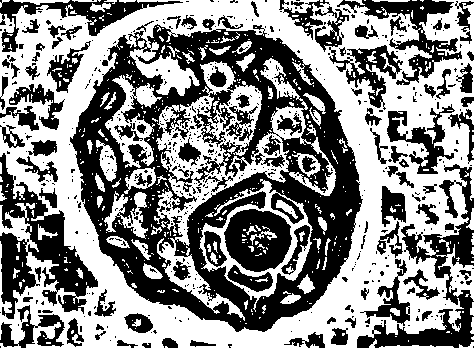 patch size = 25

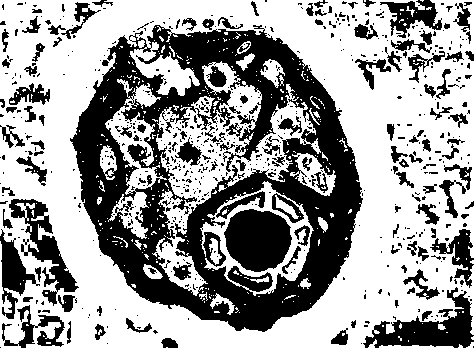 patch size = 51

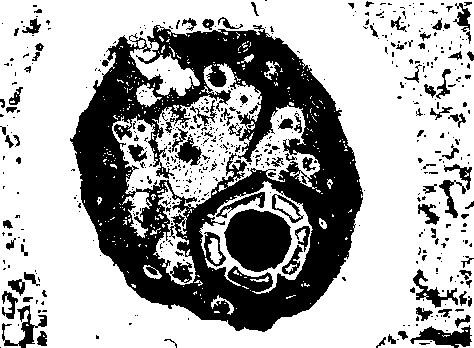 patch size = 101

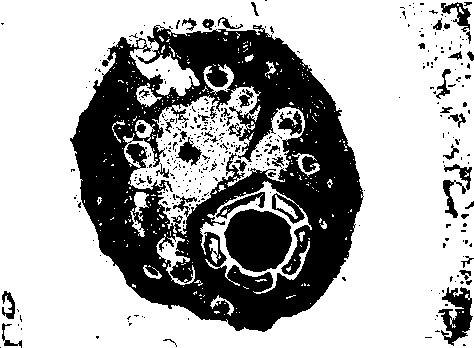 patch size = 151

可以看到，patch size选取为25时，图像非常混乱，展示了过多无效的细节；patchSize 选取为101和151时，则又出现大面积的黑色与白色，提供的信息不足。
相较而言，patch size选取为50时的图像中，细胞的整体轮廓仍然是清晰，效果最好。

3、线性插值算法及应用

将图片的分辨率放大N倍，就是向原本相邻的两个像素点之间插入N−1个像素点，也即将总的像素点数量扩大到原来的N^2倍。
实现线性插值的方法是：先在横向的维度上进行线性插值，再在纵向的维度上进行线性插值，最终完成对整张图片的分辨率扩大。

In [7]:
from math import *
import numpy as np
from PIL import Image


def main():
    myPicture = 'Hitler.png'
    im_raw = Image.open(myPicture)
    im = im_raw.convert('L')
    pixels = np.array(im)
    N = int(input('请输入图片放大倍数N：'))
    pixels2 = np.empty((N*pixels.shape[0],N*pixels.shape[1]))

    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            pixels2[N*i,N*j] = pixels[i,j]

    for i in range(pixels.shape[0]): # 在横向进行线性插值
        for j in range(pixels.shape[1] - 1):
            Ni = N*i
            Nj = N*j
            for k in range(1,N):
                pixels2[Ni,Nj+k] = ((N-k)/N)*pixels[i,j] + (k/N)*pixels[i,j+1]
    
    for i in range(pixels.shape[0]-1): # 在纵向进行线性插值
        Ni = N*i
        for j in range(pixels.shape[1]-1):
            Nj = N*j
            for p in range(1,N):
                for q in range(N+1):
                    pixels2[Ni+p,Nj+q] = ((N-p)/N)*pixels2[Ni,Nj+q] + (p/N)*pixels2[Ni+N,Nj+q]

    pixels2 = pixels2.astype(np.uint8)
    new_im = Image.fromarray(pixels2)
    new_im.save('线性插值_'+str(myPicture)+'_N='+str(N)+'.png')


if __name__ == '__main__':
    main()

请输入图片放大倍数N： 4


输入图片与放大倍数后，输出结果如下：

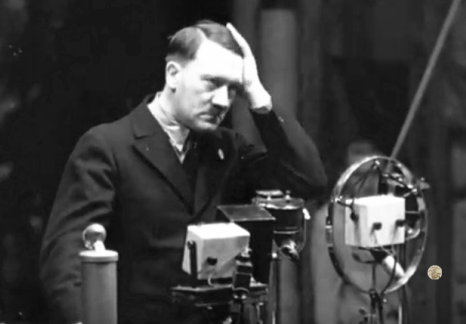 原图

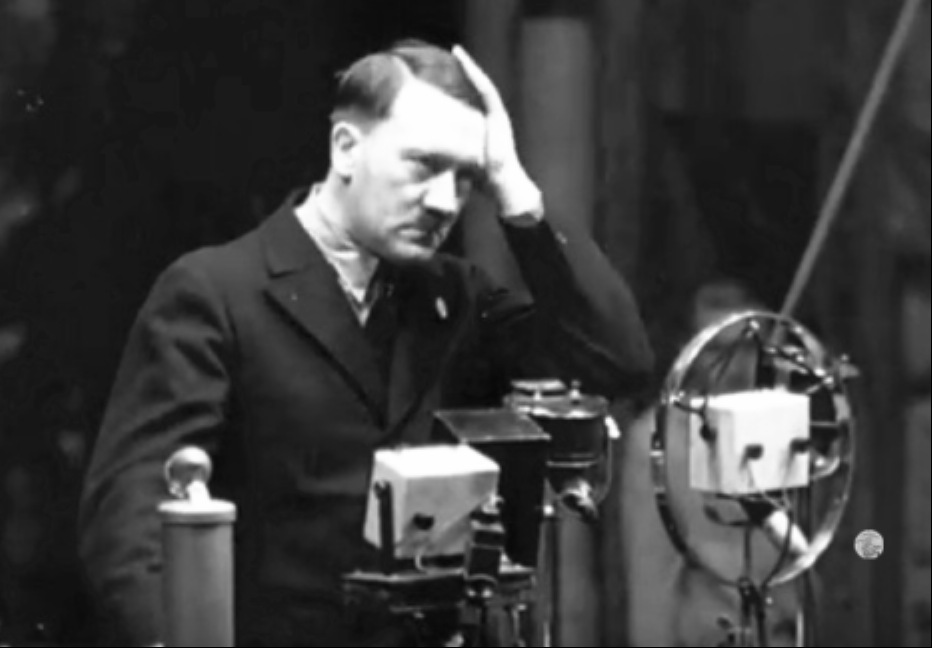 放大倍数N=2

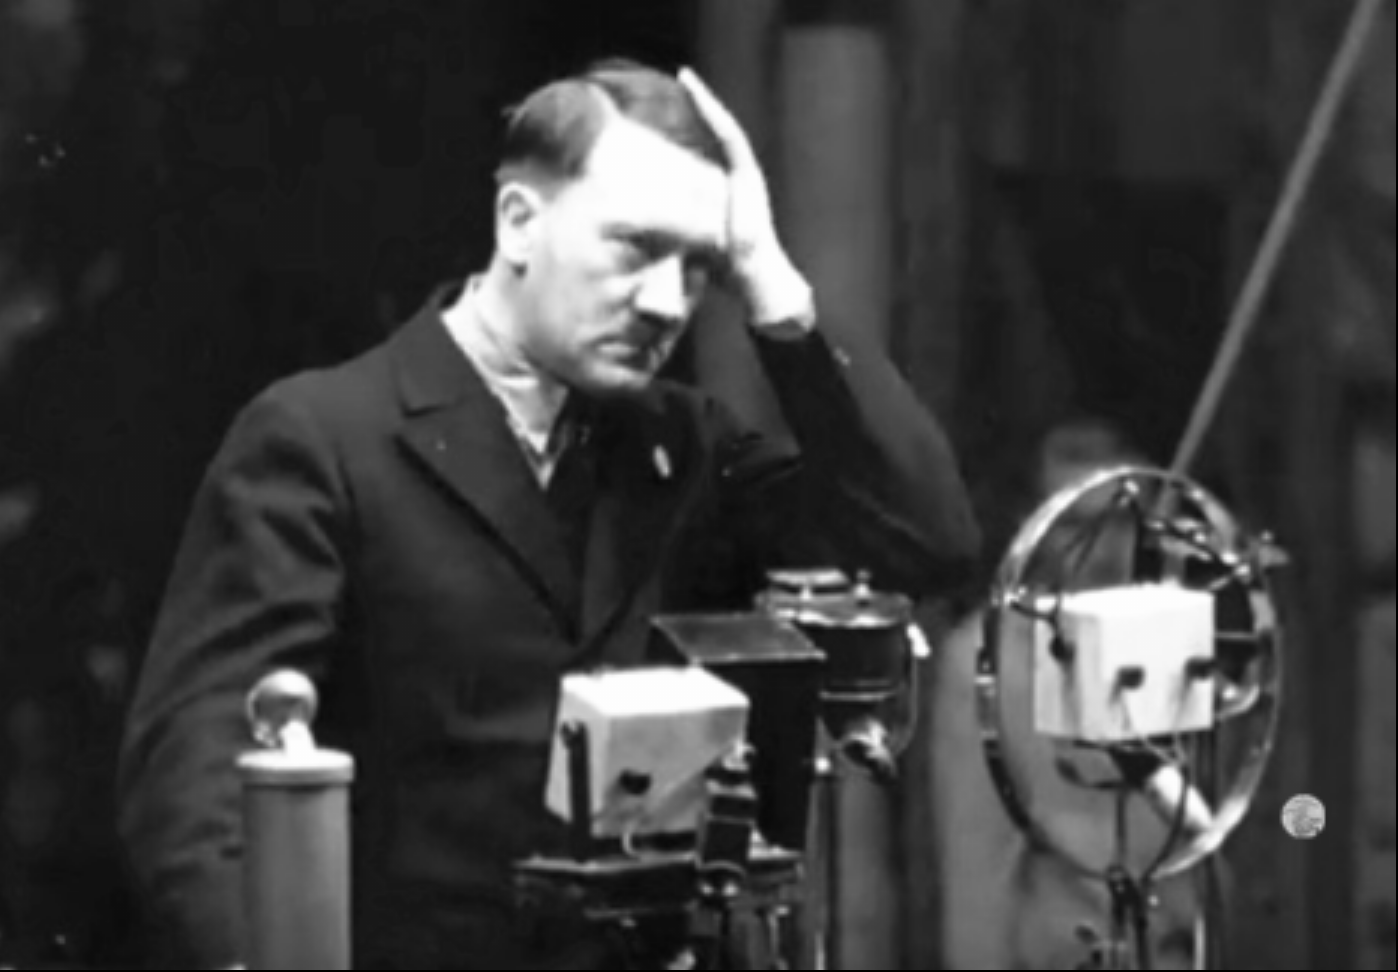 放大倍数N=3

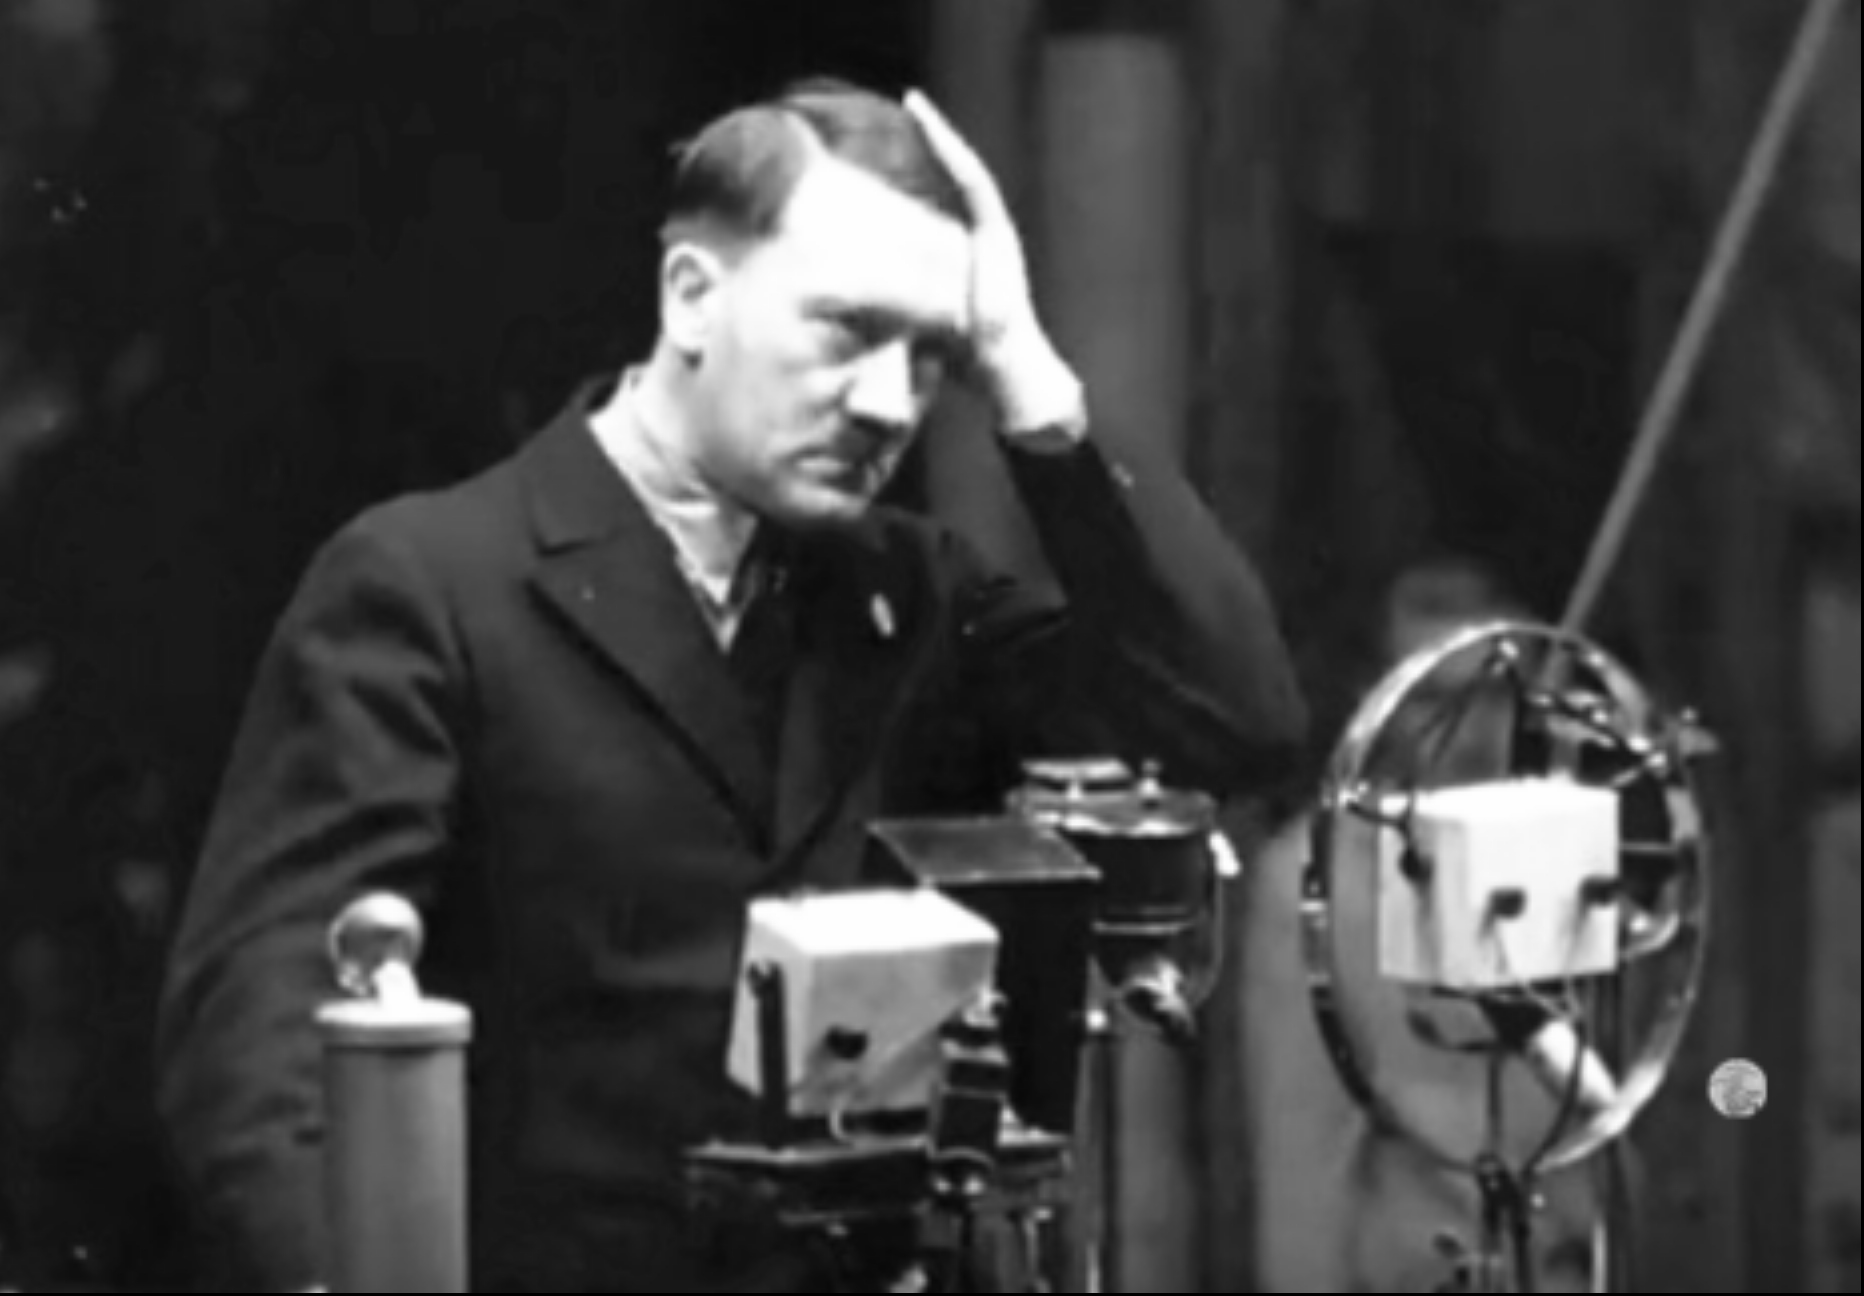 放大倍数N=4

可以看到，经过线性插值处理后，分辨率放大的图片并未出现“棋盘状”的纹路，而是仍能保持较好的清晰度。